# Introduction to Recurrent Neural Networks based on the Example of Stock Price Prediction


A RNN is a type of artificial neural network designed for sequential data processing, where the current input is related to previous inputs. This characteristic makes RNNs particularly well-suited for tasks involving time series or sequences, such as financial forecasting. In this notebook, we show how a simple recurrent neural network (RNN) model can be used for the prediction of stock price dynamics. Thereby, relevant principles are introduced with a focus on the design and training of a simple RNN in tensorflow. For simplicity, limit ourselves to the simple case of a single stock price time series.

## Import 

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings("ignore")

## Load and plot data 

We collected stock data for Apple on 880 trading days, from January 1, 2020, to July 1, 2023. These stock data includes volumes and opening, closing,
highest, lowest, and adjusted closing prices. We load data using the Python package Yahoo Finance (yfinance).


In [2]:
stock_data = yf.download("AAPL", start="2020-01-01", end="2023-07-15")
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.960464,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.251129,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.826866,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.484344,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.650345,132079200


In [3]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 889 entries, 2020-01-02 to 2023-07-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       889 non-null    float64
 1   High       889 non-null    float64
 2   Low        889 non-null    float64
 3   Close      889 non-null    float64
 4   Adj Close  889 non-null    float64
 5   Volume     889 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 48.6 KB


## Normalization of Data and Split the Training and Test Set

Since RNNs are sensitive to the scale of input data due to their dynamic temporal behavior, it is often helpful to normalize the time series data (e.g., to mitigate issues related to exploding or vanishing gradients).

Moreover, the data set should be split in a training and a test set, because the quality of the method is not based on the error produced with the data used for training, but it is based on the potential for generalisation of the algorithm, that is, the performance on data not previously seen. In an extreme case, overfitting can happen, such that the results for the given data are very good, but new data does not achieve an acceptable outcome. To measure this, a part of the data set should not be used for training the data, but for testing the algorithm after the training procedure.

In [4]:
data = stock_data['Close']

length_data = len(data)     
split_ratio = 0.8           
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train

train_data = data[:length_train]
dataset_train = np.array(data[:length_train])
dataset_train = np.reshape(dataset_train, (-1,1))

scaler = MinMaxScaler(feature_range = (0,1))
dataset_train_scaled = scaler.fit_transform(dataset_train)
dataset_train_scaled.shape

X_train = []
y_train = []
time_step = 50
for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

validation_data = data[length_train:]

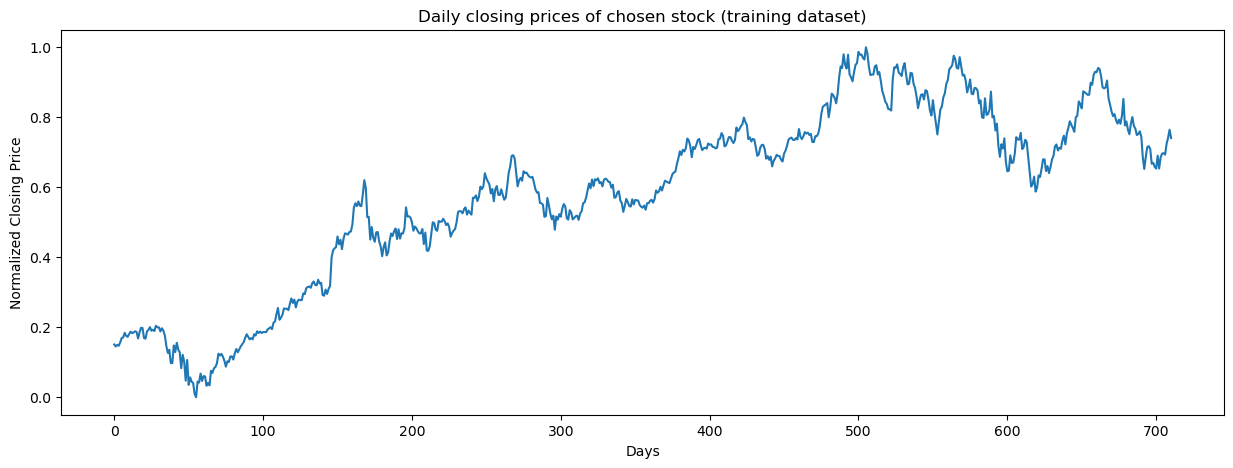

In [5]:
plt.figure(figsize=[15,5])
plt.plot(dataset_train_scaled)
plt.title('Daily closing prices of chosen stock (training dataset)')
plt.xlabel("Days")
plt.ylabel("Normalized Closing Price")
plt.show()

## Creating and Training a simple RNN

In this section, we build and train a simple RNN model ([Wiki about RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network), [Introduction to RNN](https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/)) by using the sequential keras model for a simple recurrent network in the function create_simple_RNN, which includes inner layers with the same activation function which can be specified and an output layer. Like other neural networks, RNNs consist of nodes organized into layers. However, RNNs have an additional loop mechanism that allows information to persist. In particular, each node in an RNN is not only connected to the nodes in the next layer but also has connections to itself from the previous time step (i.e., the units are recurrently connected).



In [6]:
def create_simple_RNN(units, activation='tanh',return_sequences=True,input_shape=(X_train.shape[1],1)):

    # initializing the RNN
    model = Sequential()
    # adding input layer, RNN layers and dropout regulatizations
    model.add(SimpleRNN(units=units, activation=activation, return_sequences=return_sequences, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=units, activation=activation, return_sequences=return_sequences))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=units, activation=activation, return_sequences=return_sequences))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=units))
    model.add(Dropout(0.2))
    # adding output layer
    model.add(Dense(units = 1))
    return model

## Establishing the model

We now establish the model with four hidden layers

- 50 neurons in each layer and the activation function 'tanh' for all neurons.

In [17]:
model = create_simple_RNN(units=50, activation='tanh', input_shape=(X_train.shape[1],1))

The model can be examined by calling the summary method on the model.

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50, 50)            2600      
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_5 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_6 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 50)               

## Training the model

In this section, we train the simple RNN. The performance is significantly dependent on the optimizer, where the following two problems play a decisive role:

- The optimizer finds only a local minimum which does not produce satisfying results for the neural network.
- The optimizer converges very slowly, such that the user may wrongly assume that the minimum is reached without that being the case.

Thus, it is crucial which optimizer and parameters are used.

In [19]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss = "mean_squared_error",metrics = ["accuracy"])
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
21/21 [==============================] - 3s 21ms/step - loss: 0.4450 - accuracy: 0.0030
Epoch 2/50
21/21 [==============================] - 0s 22ms/step - loss: 0.3525 - accuracy: 0.0030
Epoch 3/50
21/21 [==============================] - 0s 21ms/step - loss: 0.3548 - accuracy: 0.0000e+00
Epoch 4/50
21/21 [==============================] - 0s 22ms/step - loss: 0.2699 - accuracy: 0.0015
Epoch 5/50
21/21 [==============================] - 1s 26ms/step - loss: 0.2347 - accuracy: 0.0030
Epoch 6/50
21/21 [==============================] - 0s 22ms/step - loss: 0.2239 - accuracy: 0.0015
Epoch 7/50
21/21 [==============================] - 0s 22ms/step - loss: 0.2165 - accuracy: 0.0030
Epoch 8/50
21/21 [==============================] - 0s 23ms/step - loss: 0.1924 - accuracy: 0.0030
Epoch 9/50
21/21 [==============================] - 0s 22ms/step - loss: 0.1779 - accuracy: 0.0030
Epoch 10/50
21/21 [==============================] - 0s 22ms/step - loss: 0.1621 - accuracy: 0.0015
Epoch

## Analysis of the Model

### Training and approximation error

We do a comparison between the original time series (training data) and the predicted solution



21/21 [==============================] - 0s 7ms/step


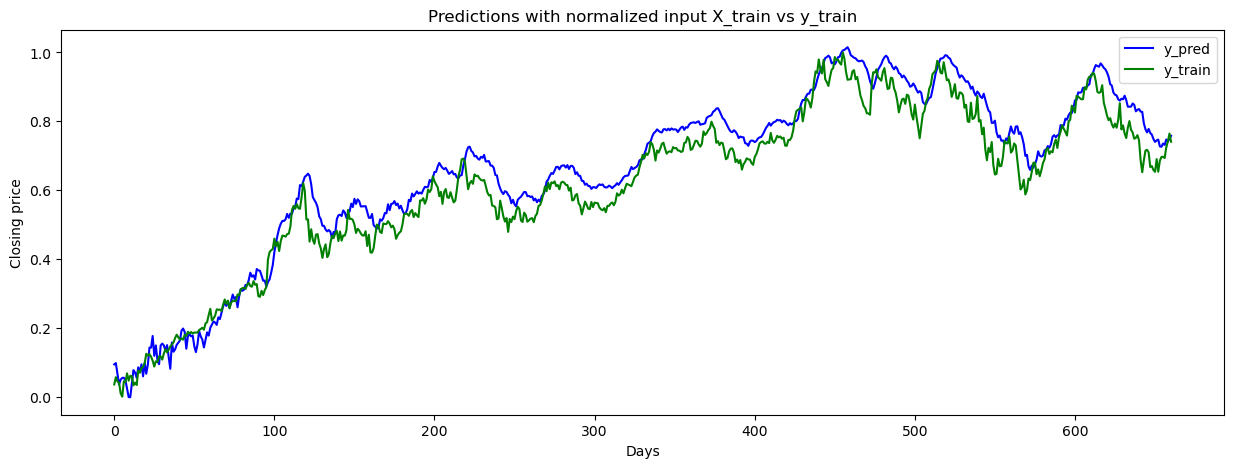

In [20]:
y_pred = model.predict(X_train) 

plt.figure(figsize=[15,5])
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.title("Predictions with normalized input X_train vs y_train")
plt.legend()
plt.show()


Now, we do the same analysis on the test set.

4/4 [==============================] - 0s 7ms/step


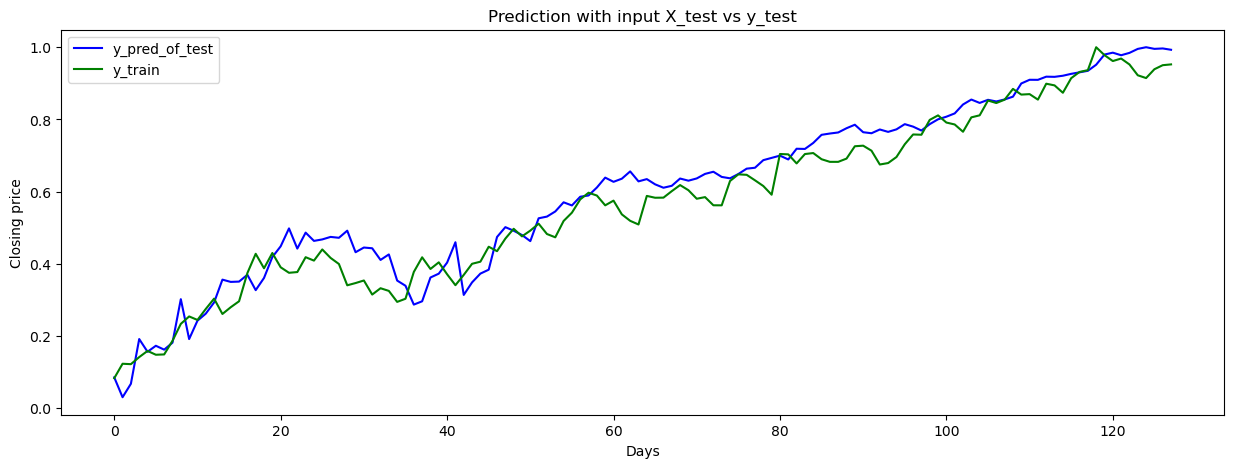

In [21]:
dataset_validation = validation_data.values  
dataset_validation = np.reshape(dataset_validation, (-1,1))  
scaled_dataset_validation =  scaler.fit_transform(dataset_validation) 

X_test = []
y_test = []
for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_test = np.reshape(y_test, (-1,1)) 


y_pred_of_test = model.predict(X_test)

plt.figure(figsize=[15,5])
plt.plot(y_pred_of_test, color = "b", label = "y_pred_of_test" )
plt.plot(y_test, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.title("Prediction with input X_test vs y_test")
plt.legend()
plt.show()

### Plotting the loss function

To receive an impression of the training of the underlying minimisation problem and assess if the computed minimum is the correct solution, there exists the possibility to plot the loss function vs. epochs.

In [22]:
print('Loss function on training data: '+ str(history.history['loss'][-1]))

Loss function on training data: 0.028771255165338516


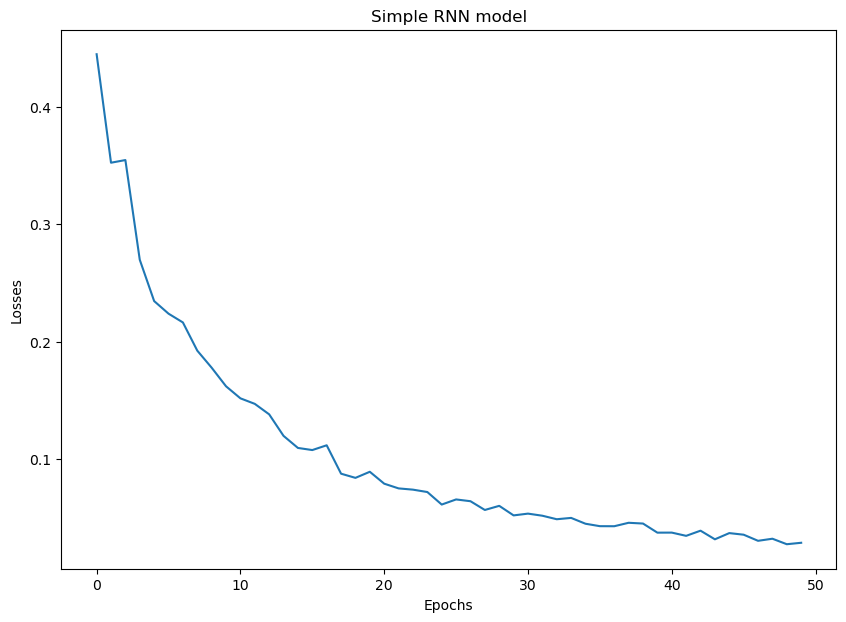

In [23]:
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model")
plt.show()

## Changing the learning rate

To get a feeling for the training behavior, the training and subsequent analysis may be conducted for various learning rates.

Epoch 1/50
21/21 [==============================] - 3s 24ms/step - loss: 0.6096 - accuracy: 0.0030
Epoch 2/50
21/21 [==============================] - 1s 25ms/step - loss: 0.4148 - accuracy: 0.0030
Epoch 3/50
21/21 [==============================] - 1s 24ms/step - loss: 0.3130 - accuracy: 0.0030
Epoch 4/50
21/21 [==============================] - 1s 24ms/step - loss: 0.2883 - accuracy: 0.0030
Epoch 5/50
21/21 [==============================] - 1s 25ms/step - loss: 0.2396 - accuracy: 0.0030
Epoch 6/50
21/21 [==============================] - 1s 25ms/step - loss: 0.2254 - accuracy: 0.0030
Epoch 7/50
21/21 [==============================] - 1s 30ms/step - loss: 0.2104 - accuracy: 0.0015
Epoch 8/50
21/21 [==============================] - 1s 24ms/step - loss: 0.1549 - accuracy: 0.0015
Epoch 9/50
21/21 [==============================] - 1s 25ms/step - loss: 0.1588 - accuracy: 0.0030
Epoch 10/50
21/21 [==============================] - 1s 26ms/step - loss: 0.1316 - accuracy: 0.0030
Epoch 11/

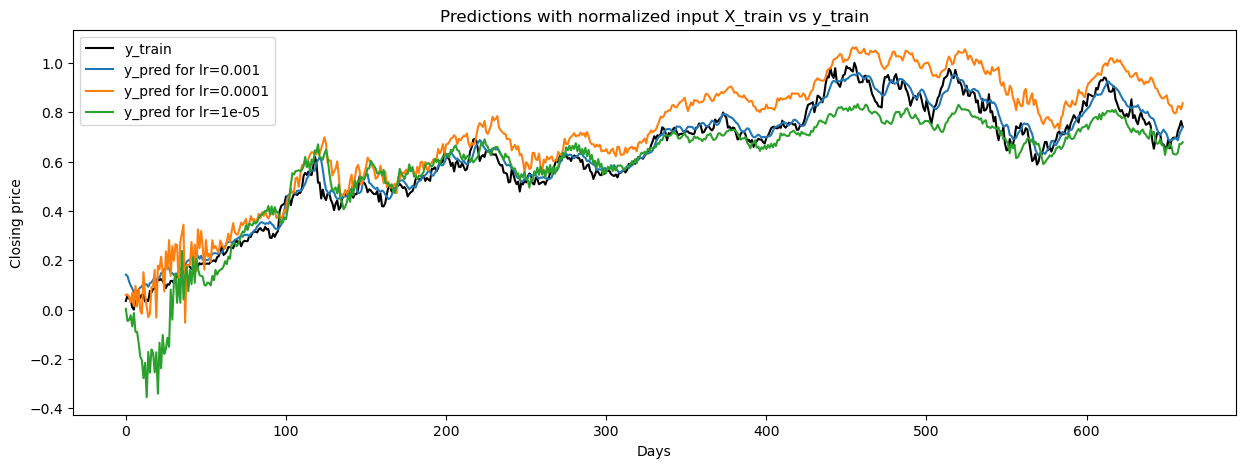

In [28]:
import tensorflow as tf
loss_list = []
plt.figure(figsize=[15,5])
plt.plot(y_train, color = "k", label = "y_train")
lr = [0.001,0.0001,0.00001]
for l in lr:
    model = create_simple_RNN(units=50, activation='tanh', input_shape=(X_train.shape[1],1))
    model.compile(optimizer=optimizers.Adam(learning_rate=l), loss = "mean_squared_error",metrics = ["accuracy"])
    tf.random.set_seed(42)
    history = history = model.fit(X_train, y_train, epochs = 50, batch_size = 32)
    loss_list.append(history.history['loss'][-1])
    y_pred = model.predict(X_train)
    plt.plot(y_pred, label = "y_pred for lr="+str(l) )

plt.xlabel("Days")
plt.ylabel("Closing price")
plt.title("Predictions with normalized input X_train vs y_train")
plt.legend()

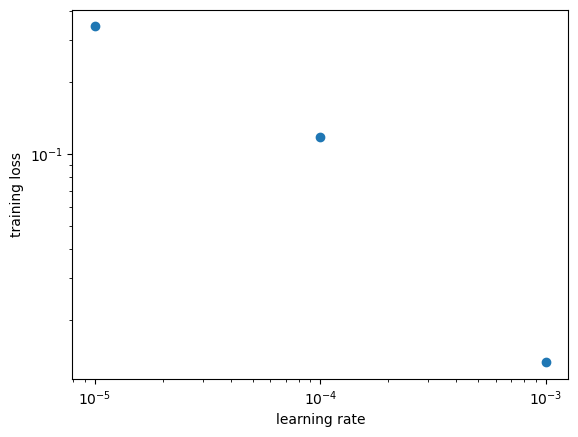

In [29]:
plt.scatter(lr,loss_list)
plt.xlabel('learning rate')
plt.ylabel('training loss')
plt.xscale('log')
plt.yscale('log')